In [2]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from PIL import Image, ImageDraw

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Init Finished!')

Init Finished!


In [3]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 256

In [4]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def load_model(model_path):
    model = resnet_cifar(depth=args_depth, num_classes=num_classes)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    print('Successfully Load Model: ', os.path.basename(model_path))
    return model

In [6]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()
# def get_weights(model):
#     conv_layers_weights = dict()
#     for name, param in model.named_parameters():
# #         print(name,param.shape)
#         conv_layers_weights[name] = param
#         if name == 'module.mask':
#             return param
        
def get_weights(model):
    return model.module.lmask.get_channel_mask()
#     return model.module.lmask.mask

In [7]:
def predict_model(PATH, title,class_index):
    use_gpu = True
    epoch = 1
    phase = 'val'
    running_corrects = 0.0
    data_len = len(dataloaders[phase])
    # print(data_len)
    true_labels = []
    model_preds = []
    model.train(False)
    for idx,data in enumerate(dataloaders[phase]):
        printF(idx, data_len)
        inputs,labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            #forward
        outputs, reg = model(inputs, labels, epoch)
        _, preds = torch.max(outputs.data, 1)
        y = labels.data
        batch_size = labels.data.shape[0]
        # print(y.resize_(batch_size,1))
        running_corrects += torch.sum(preds == y)
        # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
        true_labels.extend(y.cpu().numpy())
        model_preds.extend(preds.cpu().numpy())
    epoch_acc = float(running_corrects) /len(true_labels)
    print('%s top1 Acc:%.4f'%(phase,epoch_acc))
    
    #Draw weights
    weights = get_weights(model)
    weights = weights.cpu().detach().numpy()
    weights = np.transpose(weights)
    print(weights.shape)
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    im = ax.imshow(weights,cmap=plt.cm.jet)
    plt.colorbar(im,orientation='vertical')
    plt.title(title)
    plt.show()
    return true_labels, model_preds,weights,true_labels

In [36]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def visulizeFeature(weights,title,class_index,true_labels):
    true_labels = np.array(true_labels)
    activation_val = []
    feature = np.concatenate(features_blobs,0)

    channel = feature.shape[1]
    sample_nums = feature.shape[0]
    print(sample_nums)
    
    target_samples_index = np.where(true_labels==class_index)
    target_feature = np.mean(feature[target_samples_index],axis=0)
    print(target_feature.shape)
    
    target_feature = list(target_feature)
    activation_val = list(enumerate(target_feature))
    activation_val = sorted(activation_val,key=lambda item:item[1],reverse=True)
    
    #get top10 channel
    top10_channel = []
    for i in range(6):
        top10_channel.append(activation_val[i][0])
    
    group_activate = []
    for i in range(10):
        index = np.where(true_labels==i)
        class_feat = feature[index]
#         print(class_feat.shape)
        top10_activation = class_feat[top10_channel]
#         print(top10_activation.shape)
        group_activate.append(np.mean(top10_activation))
    
    plt.figure(figsize=(6,6))
    plt.bar(range(len(group_activate)),group_activate,tick_label=list(labels_name))
    plt.title(title)
    plt.show()

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[99%]val top1 Acc:0.7401
(10, 64)


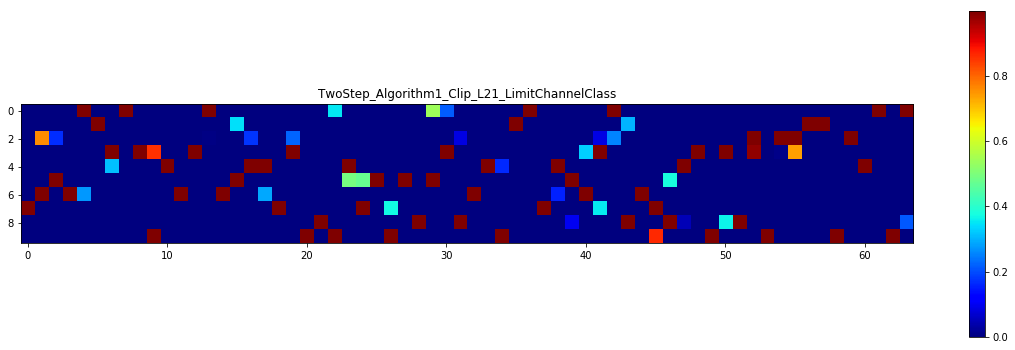

In [40]:
PATH ='/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask_baseline/TwoStep_Algorithm1_Clip_L21_LimitChannelClass'
# PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask'
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')

model = load_model(model_path)
# 该数组记录中间层结果
features_blobs = []
# 该函数由register_forward_hook调用，类似于event handler，当resnet前向传播时记录所需中间层结果
def hook_feature(module, input, output):
    output = output.data.cpu().numpy()
    batch_size = output.shape[0]
    channel = output.shape[1]
    output = np.reshape(output,(batch_size,channel,-1))
    filter_activation = np.reshape(np.mean(output,axis=-1),(batch_size,channel))
    features_blobs.append(filter_activation)
    # 需要输出的中间层名称，名称为resnet_for_vis的__init__函数中声明的。
finalconv_name = 'layer3'
# model.layer3.register_forward_hook(hook_feature)
model._modules.get('module').layer3.register_forward_hook(hook_feature)

class_index = 2
true_labels, model_preds,weights,true_labels = predict_model(model_path, title,class_index)

10000
(64,)
[(59, 1.6244324), (16, 1.5979481), (1, 1.5901221), (54, 1.5017699), (2, 1.211592), (37, 0.9914183), (52, 0.98659277), (36, 0.98382294), (61, 0.98102856), (28, 0.95676327), (6, 0.93366134), (0, 0.91101366), (7, 0.8565629), (41, 0.8379366), (43, 0.8290087), (63, 0.8186662), (60, 0.8170401), (22, 0.81355906), (27, 0.812493), (12, 0.80847913), (13, 0.80175155), (42, 0.7930291), (40, 0.7740066), (56, 0.77135736), (5, 0.75947523), (31, 0.758194), (55, 0.7450219), (19, 0.73634154), (47, 0.70960283), (30, 0.69811106), (11, 0.6946328), (18, 0.6862334), (34, 0.68528223), (25, 0.6807501), (9, 0.6742202), (48, 0.65497005), (49, 0.6524), (39, 0.650546), (20, 0.6500745), (8, 0.6461142), (14, 0.6383341), (24, 0.6353617), (4, 0.63387316), (26, 0.6276584), (29, 0.62601763), (35, 0.6246271), (57, 0.622418), (51, 0.6213056), (50, 0.61842763), (23, 0.6129604), (15, 0.6028523), (53, 0.5894947), (62, 0.5736399), (3, 0.5562093), (44, 0.5400538), (58, 0.5382399), (45, 0.5059392), (17, 0.5003467), 

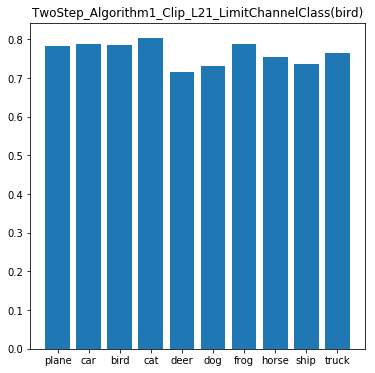

In [41]:
title = PATH.split('/')[-1]
title = title + '(' + labels_name[class_index] + ')'
visulizeFeature(weights,title,class_index,true_labels)